Modelar o ciclo de cogeração ilustrado abaixo. Permitir que o processo varie de 
0% (desligado) até 100% (completamente ligado).

![Ciclo](img/ciclo.jpeg "Ciclo")

Importando bibliotecas necessárias

In [42]:
from pandas import read_excel, DataFrame, ExcelWriter
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import State as st
from numpy import arange, absolute, nan, linspace, argmin
from sympy import symbols
from sympy.solvers.solveset import linsolve

In [43]:
df = read_excel('data.xlsx')
display(df.replace(nan, '-'))

,Temperatura [ºC],Pressão [kPa],Vazão [kg/s],Título [-]
0,485,6495,27.9,-
1,-,900,-,-
2,-,250,-,-
3,51,Saturação,-,-
4,51,Saturação,-,0.0
5,-,250,-,-
6,110,250,-,-
7,-,6495,27.9,-
8,110,250,-,-
9,-,900,-,-


Dados fornecidos

In [44]:
fluido = 'Water'
n_turb, n_pump = 0.85, 0.85
F_processo = 1

Inserindo temperatura de saturação na tabela e convertendo para K

In [45]:
T, c = [], 0

for i in df['Temperatura [ºC]']:
    c = c + 1
    try:
        if i == 'Saturação':
            T.insert(c-1, round(prop('T', 'P', df['Pressão [kPa]'][c-1], 'Q', 0, fluido), 2) )
        else:
            T.insert(c-1, i + 273.15)
    except ValueError or NameError:
        print(f'Sem informações de pressão no estado {c}')

Inserindo pressão de saturação na tabela 

In [46]:
P, c = [], 0
for i in df['Pressão [kPa]']:
    c = c + 1
    try:
        if i == 'Saturação':
            P.insert(c-1, round(prop('P', 'T', T[c-1], 'Q', 0, fluido)/10**3,2) )
        else:
            P.insert(c-1, i)
    except ValueError or NameError:
        print(f'Sem informações de temperatura no estado {c}')

Definindo valores de vazão e titulo a partir da tabela de dados

In [47]:
vazao = df['Vazão [kg/s]']
x = df['Título [-]']

## Definindo estados ##

$$ st: Estado $$

In [48]:
def estado(P=None, T=None, x=None, s=None, h=None):
    if x==None and s==None and h==None:
        return st(fluido, {'P': P, 'T': T})
    elif T==None and s==None and h==None:
        return st(fluido, {'P': P, 'Q': x})
    elif T==None and x==None and h==None:
        return st(fluido, {'P': P, 'S': s})
    elif T==None and x==None and s==None:
        return st(fluido, {'P': P, 'H': h})
    else:
        return print('Falta informações')

Definindo estados em função da pressão e temperatura com dados fornecidos

$$st: st(P, T)$$

In [49]:
def st1(p, t):
    return estado(P=p, T=t)
st7 = estado(P=P[6], T=T[6])
st9 = estado(P=P[8], T=T[8])

Definindo estados em função da pressão e titulo com dados fornecidos

$$st: st(P, x)$$

In [50]:
st5 = estado(P=P[4], x=x[4])
st11 = estado(P=P[10], x=x[10])
st12 = estado(P=P[11], x=x[11])

Definindo estados a partir da equação de eficiência isentrópica para turbinas

$$ \eta_{turb} = \frac{h_{n-1} - h_{n}}{h_{n-1} - h_{ns}} $$

Estado 2

$$ st_{2s}: st_{2s}(P_{2}, S_{1}) $$
$$ h_{2} = h_{1} - \eta_{turb}(h_{1} - h_{2s}) $$
$$ st_{2}: st_{2}(P_{2}, h_{2}) $$

In [51]:
def st2s(p, t):
    return estado(P=P[1], s=st1(p, t).s)

def st2(p, t):
    h2 = st1(p, t).h - n_turb*(st1(p, t).h - st2s(p, t).h)
    return estado(P=P[1], h=h2)

Estado 3

$$ st_{3s}: st_{3s}(P_{3}, S_{2}) $$
$$ h_{3} = h_{2} - \eta_{turb}(h_{2} - h_{3s}) $$
$$ st_{3}: st_{2}(P_{3}, h_{3}) $$

In [52]:
def st3s(p, t):
    return estado(P=P[2], s=st2(p, t).s)

def st3(p, t):
    h3 = st2(p, t).h - n_turb*(st2(p, t).h - st3s(p, t).h)
    return estado(P=P[2], h=h3)

Estado 4

$$ st_{4s}: st_{4s}(P_{4}, S_{3}) $$
$$ h_{4} = h_{3} - \eta_{turb}(h_{3} - h_{4s}) $$
$$ st_{4}: st_{4}(P_{4}, h_{4}) $$

In [53]:
def st4s(p, t):
    return estado(P=P[3], s=st3(p, t).s)

def st4(p, t):
    h4 = st3(p, t).h - n_turb*(st3(p, t).h - st4s(p, t).h)
    return estado(P=P[3], h=h4)

Definindo estados a partir da equação de eficiência isentrópica para bombas

$$ \eta_{pump} = \frac{h_{ns} - h_{n-1}}{h_{n} - h_{n-1}} $$

Estado 6

$$ st_{6s}: st_{6s}(P_{6}, S_{5}) $$
$$ h_{6} = h_{5} + \frac{h_{6s} - h_{5}}{\eta_{pump}} $$
$$ st_{6}: st_{6}(P_{6}, h_{6}) $$

In [54]:
st6s = estado(P=P[5], s=st5.s)
h6 = st5.h + (st6s.h - st5.h)/n_pump
st6 = estado(P=P[5], h=h6)

Estado 8

$$ st_{8s}: st_{8s}(P_{8}, S_{7}) $$
$$ h_{8} = h_{7} + \frac{h_{8s} - h_{7}}{\eta_{pump}} $$
$$ st_{8}: st_{8}(P_{8}, h_{8}) $$

In [55]:
def st8s(p):
    return estado(P=p, s=st7.s) #p8 = p1

def st8(p):
    h8 = st7.h + (st8s(p).h - st7.h)/n_pump
    return estado(P=P[7], h=h8)

Estado 10

$$ st_{10s}: st_{10s}(P_{10}, S_{9}) $$
$$ h_{10} = h_{9} + \frac{h_{10s} - h_{9}}{\eta_{pump}} $$
$$ st_{10}: st_{10}(P_{10}, h_{10}) $$

In [56]:
st10s = estado(P=P[9], s=st9.s)
h10 = st9.h + (st10s.h - st9.h)/n_pump
st10 = estado(P=P[9], h=h10)

## Obtendo valores de temperatura, pressão, entalpia, entropia, volume especifico e titulo para todos os estados ##

In [57]:
estds = st1(p=P[0], t=T[0]), st2(p=P[0], t=T[0]), st3(p=P[0], t=T[0]), st4(p=P[0], t=T[0]), st5, st6, st7, st8(p=P[7]), st9, st10, st11, st12

temperatura, pressao, entalpia, entropia, titulo, estados = [], [], [], [], [], arange(1, len(estds)+1, 1)

for i in estds: 
    temperatura.append(i.T - 273.15)
    pressao.append(i.p)
    entalpia.append(i.h)
    entropia.append(i.s)
    if absolute(round(i.Q, 4)) == 1:
        titulo.append('Vap. Sat.')
    elif i.Q == 0:
        titulo.append('Liq. Sat.')
    else:
        titulo.append(i.Q)

## Resolvendo o sistema de equação das vazões ##

Definindo as variaveis como simbólicas

In [58]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = symbols('m1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11 m12')
massas = m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12

$$ \frac{dm_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m} = 0 $$
$$ \frac{dE_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n}h_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m}h_{out, m} = 0 $$

$$ \dot{m}_{1}, \dot{m}_{2}, \dot{m}_{3}, \dot{m}_{4}, \dot{m}_{5}, \dot{m}_{6}, \dot{m}_{7}, \dot{m}_{8}, \dot{m}_{9}, \dot{m}_{10}, \dot{m}_{11}, \dot{m}_{12} = \left\{
\begin{array}{lr}
\dot{m}_{1} - 27,9 = 0\\
\dot{m}_{8} - 27,9 = 0\\
\dot{m}_{2} + \dot{m}_{3} + \dot{m}_{4} - \dot{m}_{1} = 0\\
\dot{m}_{12} + \dot{m}_{3} + \dot{m}_{6} - \dot{m}_{7} = 0\\
\dot{m}_{2} + \dot{m}_{10} - \dot{m}_{11} = 0\\
\dot{m}_{2}h_{2} + \dot{m}_{10}h_{10} - \dot{m}_{11}h_{11} = 0\\
\dot{m}_{12}h_{12} + \dot{m}_{3}h_{3} + \dot{m}_{6}h_{6} - \dot{m}_{7}h_{7} = 0\\
\dot{m}_{4} - \dot{m}_{5} = 0\\
\dot{m}_{5} - \dot{m}_{6} = 0\\
\dot{m}_{11} - \dot{m}_{12} = 0\\
\dot{m}_{12} - \dot{m}_{11}F_{processo} = 0\\
\dot{m}_{9} - \dot{m}_{10} = 0
\end{array}
\right. $$

In [59]:
eqs_massas = [ m1 - vazao[0], 
               m8 - vazao[7],
               m2 + m3 + m4 - m1,
               m12 + m3 + m6 - m7,
               m2 + m10 - m11,
               m2*st2(p=P[0], t=T[0]).h + m10*st10.h - m11*st11.h,
               m12*st12.h + m3*st3(p=P[0], t=T[0]).h + m6*st6.h - m7*st7.h,
               m4 - m5,
               m5 - m6,
               m11 - m12,
               m12 - vazao[10]*F_processo,
               m9 - m10 ]

Criando lista de vazões e arredondando para 2 casas decimais

In [60]:
m = [round(num, 2) for num in list(linsolve(eqs_massas, massas))[0]]

Definindo dicionário de dados dos estados e criando tabela

In [61]:
data_st = {
    'Estado': estados,
    'Temperatura [ºC]': temperatura,
    'Pressão [kPa]': pressao,
    'Entalpia [kJ/kg]': entalpia,
    'Entropia [kJ/kg/K]': entropia,
    'Vazão [kg/s]': m,
    'Titulo [-]': titulo
}

df_st = DataFrame(data_st).style.hide(axis='index').format('{:.2f}', subset=['Temperatura [ºC]', 'Pressão [kPa]', 
                                                                             'Entalpia [kJ/kg]', 'Entropia [kJ/kg/K]', 
                                                                             'Vazão [kg/s]'])

## Resultados ##

In [62]:
display(df_st.format(precision=4, subset=['Titulo [-]']))

Estado,Temperatura [ºC],Pressão [kPa],Entalpia [kJ/kg],Entropia [kJ/kg/K],Vazão [kg/s],Titulo [-]
1,485.00,6495.00,3381.20,6.79,27.90,Vap. Sat.
2,243.27,900.00,2932.08,6.95,6.49,Vap. Sat.
3,127.41,250.00,2714.68,7.05,1.34,0.9992
4,51.00,12.98,2333.14,7.26,20.07,0.8908
5,51.00,12.98,213.54,0.72,20.07,Liq. Sat.
6,51.02,250.00,213.82,0.72,20.07,Vap. Sat.
7,110.00,250.00,461.49,1.42,28.35,Vap. Sat.
8,110.75,6495.00,469.21,1.42,27.90,Vap. Sat.
9,110.00,250.00,461.49,1.42,0.45,Vap. Sat.
10,110.08,900.00,462.30,1.42,0.45,Vap. Sat.


## Trabalho, calor e eficiência ##

$$ \dot{W}_{pump, 1} = \eta_{pump}\dot{m}_{6}(h_{6} - h_{5})$$
$$ \dot{W}_{pump, 2} = \eta_{pump}\dot{m}_{8}(h_{8} - h_{7})$$
$$ \dot{W}_{pump, 3} = \eta_{pump}\dot{m}_{10}(h_{10} - h_{9})$$
$$ \dot{W}_{pump} = \dot{W}_{pump_{1}} + \dot{W}_{pump_{2}} + \dot{W}_{pump_{3}} $$

In [63]:
def W_pump(p, p1=None, p2=None, p3=None):
    if p1 is not None:
        return round(m[5]*(st6.h - st5.h)*n_pump, 2)
    if p2 is not None:
        return round(m[7]*(st8(p).h - st7.h)*n_pump, 2)
    if p3 is not None:
        return round(m[9]*(st10.h - st9.h)*n_pump, 2)
    return round(n_pump*(m[5]*(st6.h - st5.h)+ m[7]*(st8(p).h - st7.h) + m[9]*(st10.h - st9.h)), 2)

$$ \dot{W}_{turb} = \eta_{turb}(\dot{m}_{1}h_{1} - (\dot{m}_{2}h_{2} + \dot{m}_{3}h_{3} + \dot{m}_{4}h_{4} ))   $$

In [64]:
def W_turb(p, t):
    return round(n_turb*( m[0]*st1(p, t).h - (m[1]*st2(p, t).h + m[2]*st3(p, t).h + m[3]*st4(p, t).h) ), 2)

$$ \dot{W}_{liq} = \dot{W}_{turb} - \dot{W}_{pump}  $$

In [65]:
def W_liq(p, t):
    return W_turb(p, t) - W_pump(p)

$$ \dot{Q}_{cald} = \dot{m}_{8}(h_{1} - h_{8}) $$

In [66]:
def Q_cald(p, t):
    return round(m[7]*(st1(p, t).h - st8(p).h), 2)

$$ \eta_{ciclo} = \frac{\dot{W}_{liq}}{\dot{Q}_{cald}} $$

In [67]:
def n_ciclo(p, t):
    return round(100*W_liq(p, t)/Q_cald(p, t), 2)

Definindo dicionário de dados de trabalho, calor e eficiêcia e criando tabela

In [68]:
data = {
    'W_pump_1 [kW]': [W_pump(p=P[0], p1=True)],
    'W_pump_2 [kW]': W_pump(p=P[0], p2=True),
    'W_pump_3 [kW]': W_pump(p=P[0], p3=True),
    'W_pump [kW]': W_pump(p=P[0]),
    'W_turb [kW]': W_turb(p=P[0], t=T[0]),
    'W_liq [kW]': W_liq(p=P[0], t=T[0]),
    'Q_cal [kW]': Q_cald(p=P[0], t=T[0]),
    'η_ciclo [%]': n_ciclo(p=P[0], t=T[0])  
}

df_res = DataFrame(data).style.hide(axis='index').format(precision=2)

## Resultados ##

In [69]:
display(df_res)

W_pump_1 [kW],W_pump_2 [kW],W_pump_3 [kW],W_pump [kW],W_turb [kW],W_liq [kW],Q_cal [kW],η_ciclo [%]
4.82,182.96,0.31,188.08,21114.86,20926.78,81244.19,25.76


## Gráficos ##

In [70]:
import matplotlib.pyplot as plt

Digrama T-s

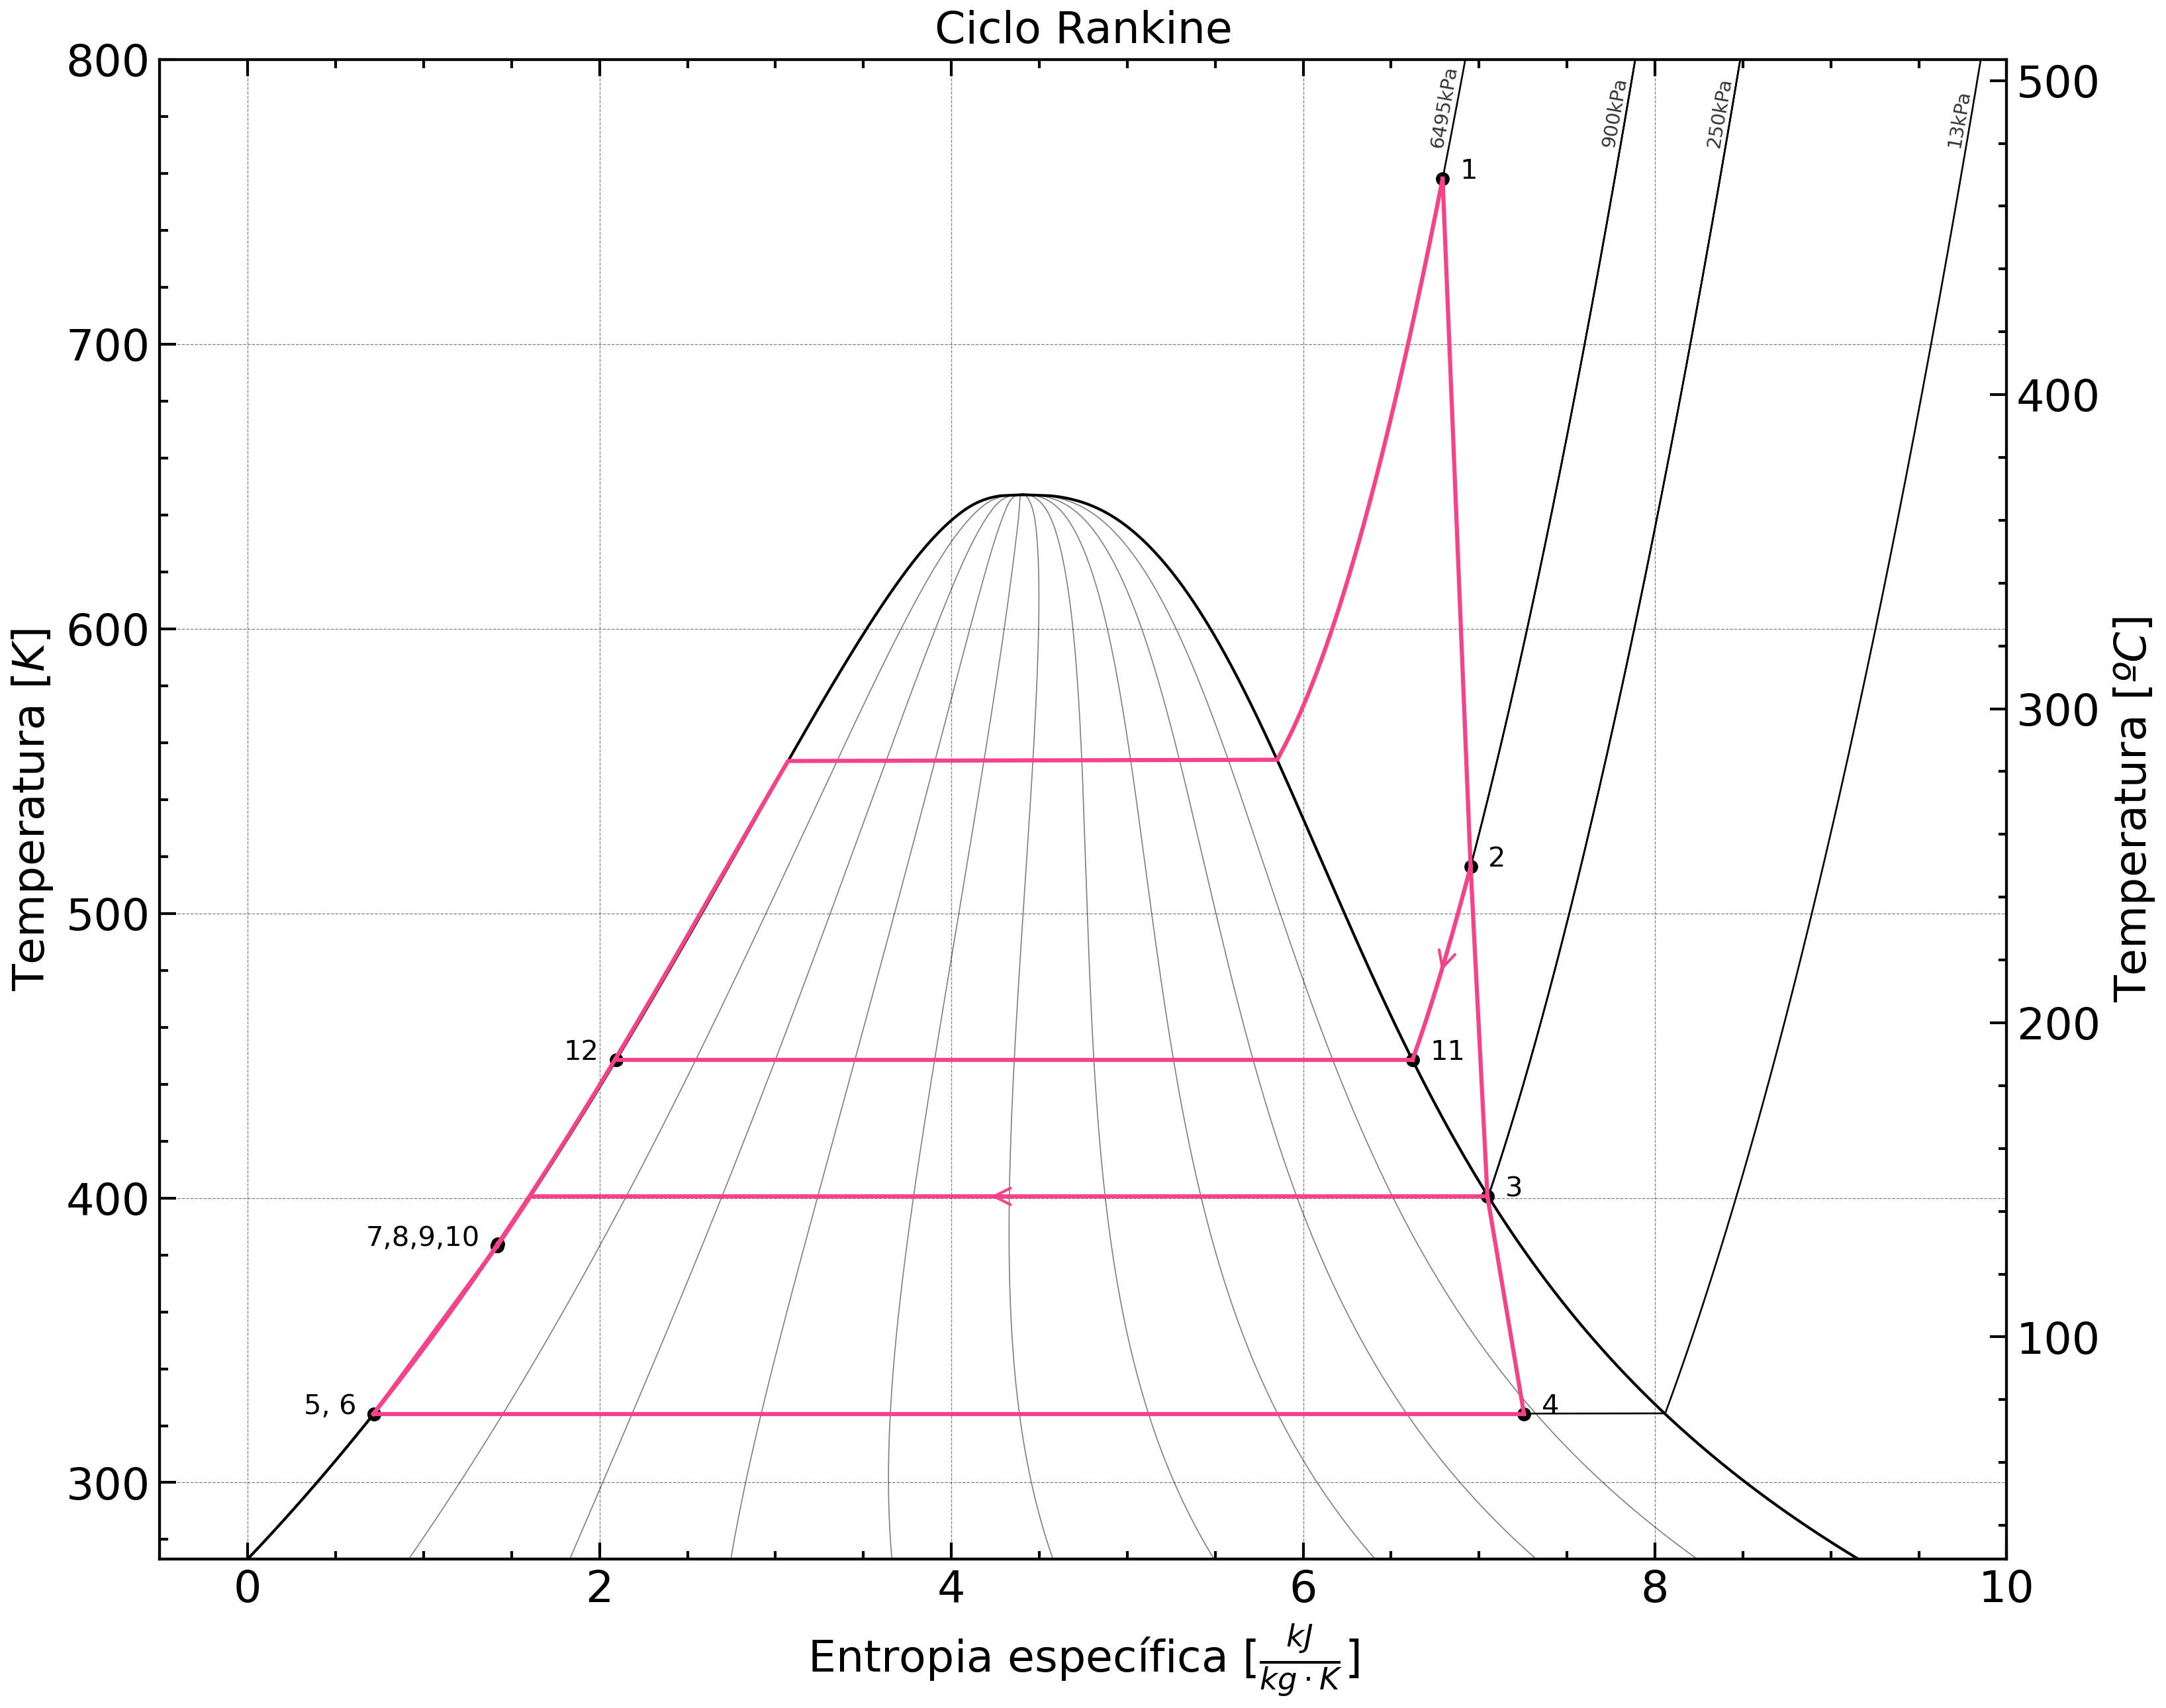

In [71]:
plt.figure(dpi=300, figsize=(12, 10))


#adicionando flexas nas linhas
def add_arrow(line, position=None, direction='right', size=15, color=None):

    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    start_ind = argmin(absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


#limite dos eixos
plt.ylim(273.15, 800)
plt.xlim(-0.5, 10)

Tmin, Tcrit, Pcrit = prop('Tmin', fluido), prop('Tcrit', fluido), prop('Pcrit', fluido)
T_array = linspace(Tmin, Tcrit, 10**3)

#Linhas de entropia
for c in arange(0.1, 1, 0.1):
  s = prop('S', 'T', T_array, 'Q', c, fluido)/10**3
  plt.plot(s, T_array, color='black', alpha=0.5, lw=0.4)

#Linhas de pressão constante:
for c in P:
  s = prop('S', 'T', linspace(Tmin, 800, 10**3), 'P', c*10**3, fluido)/10**3
  plt.plot(s, linspace(Tmin, 800, 10**3), color='black',alpha=0.8, lw=0.6)
  
#Inserindo nome nas linhas de pressão constante
def entropy(p):
  return prop('S', 'P', p*10**3, 'T', 770, fluido)/10**3

plt.text(entropy(p=P[0])-0.12, 770, f'{P[0]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
plt.text(entropy(p=P[1])-0.12, 770, f'{P[1]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
plt.text(entropy(p=P[2])-0.12, 770, f'{P[2]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
plt.text(entropy(p=P[3])-0.12, 770, f'{P[3]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)

#Domo:
s = prop('S','T' ,T_array ,'Q',0 ,fluido)/10**3
plt.plot(s, T_array, color='black', lw=1)
s = prop('S', 'T', T_array, 'Q', 1, fluido)/10**3
plt.plot(s, T_array, color='black', lw=1)

#Convertendo temperatura para K
temperatura_k = list(map(lambda x: x+273.15, temperatura)) 

#Inserindo pontos
plt.plot(entropia, temperatura_k, 'o', color='black', markersize=4, alpha=1) 

#Ciclo
T_var = linspace(max(temperatura_k), min(temperatura_k), 1000)
s = prop('S','P', P[0]*10**3, 'T',T_var,'Water')/10**3
plt.plot(s,T_var,'#f5428a',lw=1.5)

for c in range(len(estados)-3):
    c = c+1
    plt.plot([entropia[c-1], entropia[c]],[temperatura_k[c-1], temperatura_k[c]],color='#f5428a',lw=1.5)

plt.plot([entropia[10], entropia[11]],[temperatura_k[10], temperatura_k[11]],color='#f5428a',lw=1.5)

#estado 3 - 7
s = linspace(entropia[2], entropia[6], 1000)
T = prop('T','S',s*10**3,'P', P[2]*10**3, fluido)
add_arrow(line=plt.plot(s,T, color='#f5428a', lw=1.5)[0])

#estado 2 - 11
s = linspace(entropia[1], entropia[10], 1000)
T = prop('T','S',s*10**3,'P', P[1]*10**3, fluido)
add_arrow(line=plt.plot(s,T,'#f5428a', lw=1.5)[0])

#Inserindo nome nos pontos
plt.text(entropia[0]+0.1, temperatura_k[0], '1',ha='left')
plt.text(entropia[1]+0.1, temperatura_k[1], '2',ha='left')
plt.text(entropia[2]+0.1, temperatura_k[2], '3',ha='left')
plt.text(entropia[3]+0.1, temperatura_k[3], '4',ha='left')
plt.text(entropia[4]-0.1, temperatura_k[4], '5, 6',ha='right')
plt.text(entropia[6]-0.1, temperatura_k[6], '7,8,9,10',ha='right')
plt.text(entropia[10]+0.1, temperatura_k[10], '11',ha='left')
plt.text(entropia[11]-0.1, temperatura_k[11], '12',ha='right')

plt.grid(ls='--', lw=0.3)
plt.title('Ciclo Rankine')
plt.xlabel(r'Entropia específica $[\frac{kJ}{kg \cdot K}]$')
plt.ylabel(r'Temperatura $[K]$')

plt.twinx()
plt.ylabel(r'Temperatura $[ºC]$',color='black')
plt.plot(temperatura, alpha=0)
plt.tick_params(axis='y', labelcolor='black', grid_alpha=0)


plt.show()

[]

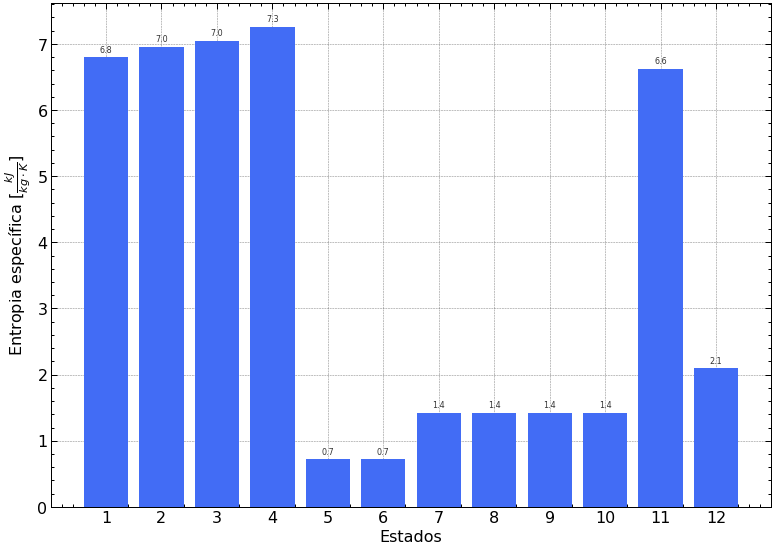

In [72]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(estados)
for bar in ax.bar(estados, entropia, color='#426cf5'):
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.08,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      alpha = 0.8,
      fontsize = 8,
      weight='regular'
  )
ax.set_xlabel('Estados')
ax.set_ylabel(r'Entropia específica $[\frac{kJ}{kg \cdot K}]$')
plt.plot()

[]

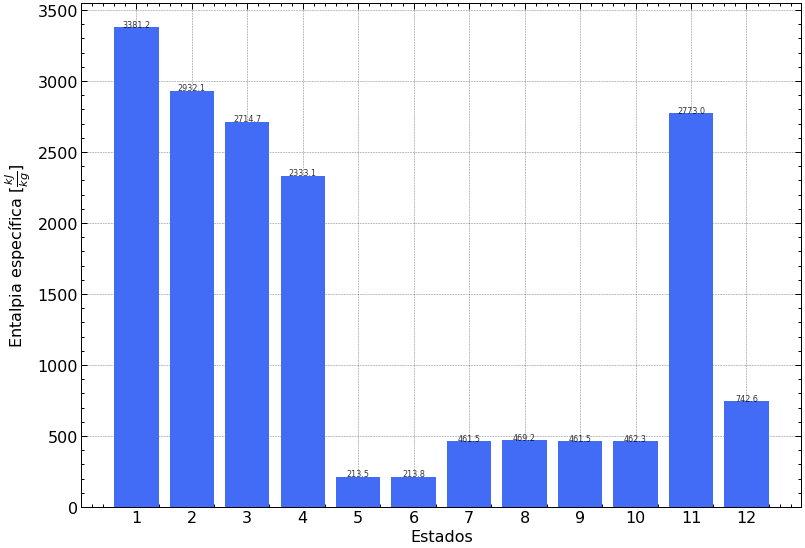

In [73]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0,0,1,1])

ax.set_xticks(estados)

for bar in ax.bar(estados, entalpia, color='#426cf5'):
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.1,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      alpha = 0.8,
      fontsize = 8,
      weight='regular'
  )

ax.set_xlabel('Estados')
ax.set_ylabel(r'Entalpia específica $[\frac{kJ}{kg}]$')
plt.plot()

In [74]:
pressure = arange(500, 20000+100, 100)
temper = arange(300, 1000+84, 4)

array_n_t1 = []
array_n_p1 = []
array_n = []

for c in range(len(pressure)):
    array_n_t1.append(n_ciclo(p=pressure[c], t=temperatura_k[0]))
    array_n_p1.append(n_ciclo(p=P[0], t=temper[c]))
    array_n.append(n_ciclo(p=pressure[c], t=temper[c]))

In [75]:
plt.style.use(['science', 'notebook', 'grid'])

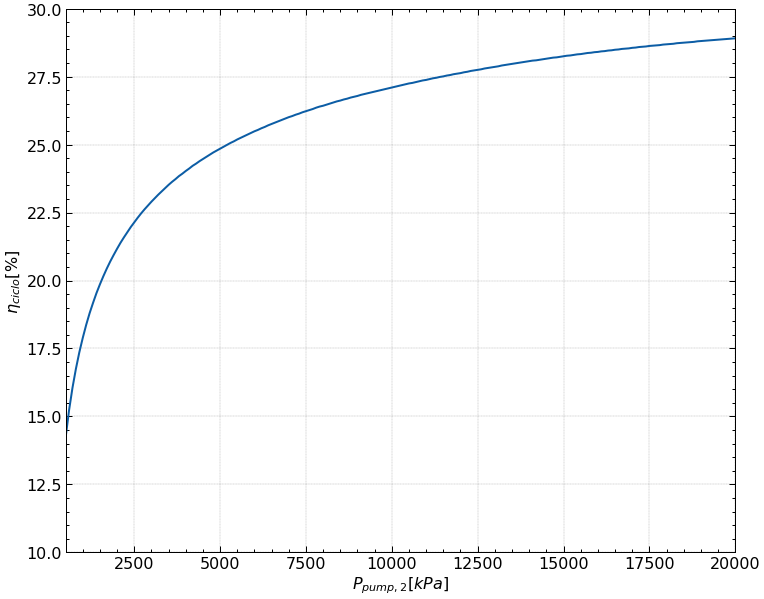

In [76]:
plt.figure(figsize=(12, 10))
plt.plot(pressure, array_n_t1)
plt.xlim(500, 20000)
plt.ylim(10, 30)
plt.ylabel(r'$\eta_{ciclo}$[%]')
plt.xlabel(r'$P_{pump, 2} [kPa]$')
plt.grid(ls='--', lw=0.3)
plt.show()

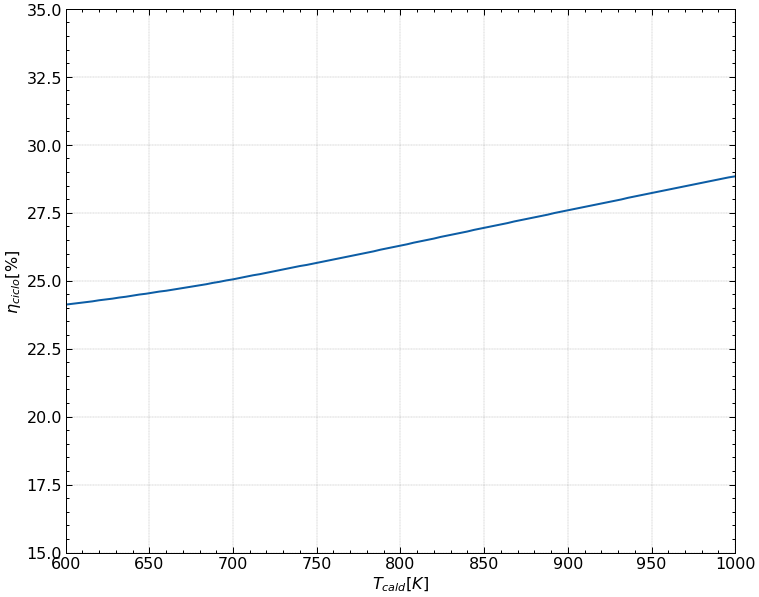

In [77]:
plt.figure(figsize=(12, 10))
plt.plot(temper, array_n_p1)
plt.xlim(600, 1000)
plt.ylim(15, 35)
plt.ylabel(r'$\eta_{ciclo}$[%]')
plt.xlabel(r'$T_{cald} [K]$')
plt.grid(ls='--', lw=0.3)
plt.show()

Exportando tabelas pro excel

In [78]:
def save_xls(dict_df, path):

    writer = ExcelWriter(path)
    for key in dict_df:
        dict_df[key].to_excel(writer, key, index=False)

    writer.save()

dict_df = {
    'Entradas': df,
    'Estados': df_st,
    'Resultados': df_res
}

path = r'resultados.xlsx'

save_xls(dict_df, path)

Fazer a modelagem com condensador para que sua temperatura de condensação 
varie conforme a vazão de condensado. Mostrar essa variação.

![Condensador](img/Condensador.jpeg "Condensador")

Desenvolver a análise de primeira lei para o esquema de caldeira abaixo. 
Considerar que este sistema está inserido dentro do ciclo de potência já desenvolvido 
(Fig. 1).


![Caldeira](img/Caldeira.jpeg "Caldeira")